<a href="https://colab.research.google.com/github/weso500/QMLIIOT/blob/main/Residual.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

# Load the training data
train_df = pd.read_csv('/content/drive/MyDrive/QMLIIOT/Train.csv')

# Load the test data
test_df = pd.read_csv('/content/drive/MyDrive/QMLIIOT/Test.csv')
print(test_df.shape)

# Convert training features to numpy array and select 100 samples
train_features = train_df.to_numpy()[:100]

test_features= test_df.to_numpy()
test_features = np.concatenate((test_features[:50], test_features[505:]))

# Create target arrays for training and testing data
test_target = np.concatenate((np.zeros(50), np.ones(5)))

# Ensure arrays are of size samples*8 (assuming 8 is the number of features)
print(f"Shape of train_features: {train_features.shape}")
print(f"Shape of test_features: {test_features.shape}")
print(f"Shape of test_target: {test_target.shape}")

(510, 8)
Shape of train_features: (100, 8)
Shape of test_features: (55, 8)
Shape of test_target: (55,)


In [ ]:
pip install qiskit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 1.5 MB/s eta 0:00:00


In [ ]:
pip install qiskit_machine_learning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 11.0 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.2
    Uninstalling scipy-1.16.2:
      Successfully uninstalled scipy-1.16.2
  Attempting uninstall: qiskit
    Found existing installation: qiskit 2.2.2
    Uninstalling qiskit-2.2.2:
      Successfully uninstalled qiskit-2.2.2


[Linear OCSVM] AUC=0.518 (nu=0.01)
[kNN-dist (quantum space)] AUC=0.502 (k=20)

Best detector: Linear OCSVM  AUC=0.518
Confusion matrix @Youden:
 [[50  0]
 [ 8  2]]
              precision    recall  f1-score   support

         0.0      0.862     1.000     0.926        50
         1.0      1.000     0.200     0.333        10

    accuracy                          0.867        60
   macro avg      0.931     0.600     0.630        60
weighted avg      0.885     0.867     0.827        60



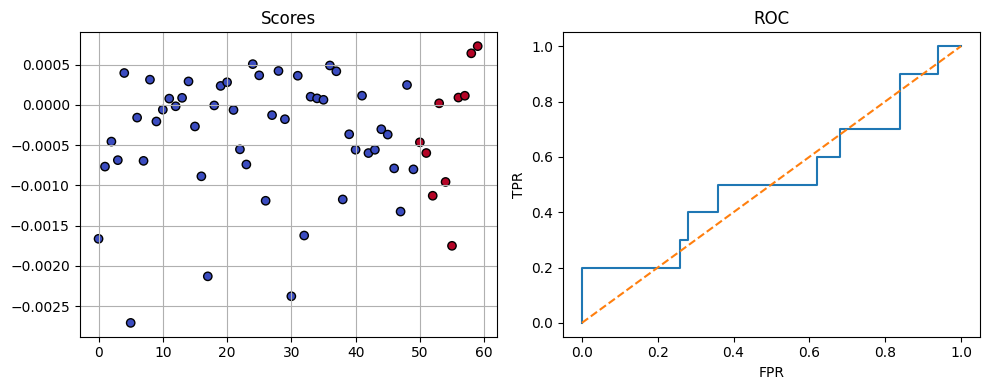

In [ ]:
# ================== HQ-RKAD: Hybrid Quantum Residual Kernel AD ==================
import numpy as np, pandas as pd, matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.kernel_approximation import Nystroem
from sklearn.svm import OneClassSVM
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report

# --- Qiskit (new API paths; works on 1.2+) ---
from qiskit.primitives import StatevectorSampler
from qiskit_machine_learning.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit.circuit.library import PauliFeatureMap

# ================== Config (tweak these) ==================
CSV_TRAIN = '/content/drive/MyDrive/QMLIIOT/TEP9Train.csv'  # normals
CSV_TEST  = '/content/drive/MyDrive/QMLIIOT/TEP9Test.csv'   # mix
TEST_TARGET = np.concatenate([np.zeros(50), np.ones(10)])    # adapt if needed

USE_RESIDUALS = False      # True = add PCA recon-error residual as 1 extra feature (cheap & helpful)
ROLL_W = 5                 # rolling window for mean
PCA_DIMS = 8               # qubits (keep 6–10)
NYSTROEM_M = 128           # landmark count for Φ features (fast & strong)
NU_GRID = [0.01, 0.02, 0.05]  # OCSVM nu candidates
SCALE = 0.3                # angle scale after z-scoring (0.2–0.5 typical)
FEATURE_MAP = 'pauli'      # 'pauli' or 'iqp'

# ================== 1) Load ==================
train_df = pd.read_csv(CSV_TRAIN)
test_df  = pd.read_csv(CSV_TEST)

# ================== 2) Tiny temporal features (diff + mean5) ==================
def quick_temporal(df, w=5):
    X = df.values
    dx = np.vstack([np.zeros((1, X.shape[1])), np.diff(X, axis=0)])
    ma = pd.DataFrame(X).rolling(w, min_periods=1).mean().values
    return np.hstack([X, dx, ma])

Xtr_raw = train_df
Xte_raw = test_df

# ================== 3) Standardize (fit on train normals only) ==================
scaler = StandardScaler().fit(Xtr_raw)
Xtr_s = scaler.transform(Xtr_raw)
Xte_s = scaler.transform(Xte_raw)

# ================== 4) Residual (optional, fast PCA recon error) ==================
if USE_RESIDUALS:
    pca_res = PCA(n_components=min( min(16, Xtr_s.shape[1]-1), 64 ), random_state=42).fit(Xtr_s)
    Rtr = np.abs(Xtr_s - pca_res.inverse_transform(pca_res.transform(Xtr_s))).mean(axis=1, keepdims=True)
    Rte = np.abs(Xte_s - pca_res.inverse_transform(pca_res.transform(Xte_s))).mean(axis=1, keepdims=True)
    Xtr_s = np.hstack([Xtr_s, Rtr])
    Xte_s = np.hstack([Xte_s, Rte])

# ================== 5) PCA -> qubit dimension ==================
pca = PCA(n_components=PCA_DIMS, random_state=42).fit(Xtr_s)
Xtr = pca.transform(Xtr_s)
Xte = pca.transform(Xte_s)

# ================== 6) Quantum kernel (Pauli or IQP; shallow & linear ent.) ==================
if FEATURE_MAP == 'pauli':
    fmap = PauliFeatureMap(feature_dimension=PCA_DIMS, paulis=['Z','ZZ'], reps=1, entanglement='linear')
else:
    fmap = IQPFeatureMap(feature_dimension=PCA_DIMS, reps=1, entanglement='linear')

sampler = StatevectorSampler()
fidelity = ComputeUncompute(sampler=sampler)
qk = FidelityQuantumKernel(fidelity=fidelity, feature_map=fmap, enforce_psd=True)

# Helper to compute centered Gram (train) and rectangular (test vs train)
def centered_gram(XA, XB=None, scale=1.0):
    if XB is None:
        K = qk.evaluate(x_vec=scale*XA)
        # double-centering
        m = K.mean(0, keepdims=True)
        Kc = K - m - m.T + K.mean()
        return Kc, K  # return raw too if needed
    else:
        K = qk.evaluate(x_vec=scale*XA, y_vec=scale*XB)
        # center using train stats
        Ktr_raw = centered_gram.cached_Ktr_raw
        m_t = Ktr_raw.mean(0, keepdims=True)        # (1,n)
        m_s = K.mean(1, keepdims=True)              # (n_test,1)  (not used directly)
        Kc = K - m_t - K.mean(1, keepdims=True) + Ktr_raw.mean()
        return Kc

# cache train raw kernel for centering test consistently
Ktr_c, Ktr_raw = centered_gram(Xtr, scale=SCALE)
centered_gram.cached_Ktr_raw = Ktr_raw
Kte_c = centered_gram(Xte, XB=Xtr, scale=SCALE)

# ================== 7) Nyström features (explicit Φ) ==================
# Map kernels to m-dim explicit features; train linear models fast
# --- Replace this block ---
# Phi = Nystroem(kernel='precomputed', n_components=min(NYSTROEM_M, Ktr_c.shape[0]-1), random_state=42)
# Ztr = Phi.fit_transform(Ktr_c)
# Zte = Phi.transform(Kte_c)

# --- With this: ---
m = min(NYSTROEM_M, Xtr.shape[0]-1)

def qkernel_func(XA, XB=None):
    return qk.evaluate(x_vec=SCALE*XA, y_vec=None if XB is None else SCALE*XB)

Phi = Nystroem(kernel=qkernel_func, n_components=m, random_state=42)
Ztr = Phi.fit_transform(Xtr)
Zte = Phi.transform(Xte)


# ================== 8) Detectors: Linear OCSVM and kNN-distance (quantum metric) ==================
# (A) Linear OCSVM on Nyström features
best_auc, best_nu, best_scores = -1, None, None
for nu in NU_GRID:
    oc = OneClassSVM(kernel='linear', nu=nu).fit(Ztr)
    scores = -oc.decision_function(Zte)
    auc = roc_auc_score(TEST_TARGET, scores)
    if auc > best_auc:
        best_auc, best_nu, best_scores = auc, nu, scores

print(f"[Linear OCSVM] AUC={best_auc:.3f} (nu={best_nu})")

# (B) Simple kNN-distance in quantum metric (no training), on centered kernels
def kernel_to_dist(Kaa, Kab):
    # D(test,train) = sqrt(Kaa_diag + Kbb_diag - 2*Kab)
    a = np.diag(Kaa) if Kaa.ndim==2 else Kaa  # handle vector
    b = np.diag(centered_gram.cached_Ktr_raw)
    return np.sqrt(np.maximum(0, np.add.outer(a, b) - 2*Kab))

# Need centered self-sim for test; approximate with diagonal of uncentered test kernel
Kaa_test = qk.evaluate(x_vec=SCALE*Xte)  # quick; size n_test x n_test
Dte = kernel_to_dist(np.diag(Kaa_test), Kte_c + centered_gram.cached_Ktr_raw.mean())  # rough centering adjust
k = 20
idx = np.argpartition(Dte, k, axis=1)[:, :k]
knn_scores = np.take_along_axis(Dte, idx, axis=1).mean(axis=1)
knn_auc = roc_auc_score(TEST_TARGET, knn_scores)
print(f"[kNN-dist (quantum space)] AUC={knn_auc:.3f} (k={k})")

# ================== 9) Report & quick plots ==================
best_name = "Linear OCSVM" if best_auc >= knn_auc else "kNN-dist"
final_scores = best_scores if best_auc >= knn_auc else knn_scores
final_auc = max(best_auc, knn_auc)

fpr, tpr, thr = roc_curve(TEST_TARGET, final_scores)
opt = np.argmax(tpr - fpr)
thr_star = thr[opt]
pred = (final_scores >= thr_star).astype(int)

print(f"\nBest detector: {best_name}  AUC={final_auc:.3f}")
print("Confusion matrix @Youden:\n", confusion_matrix(TEST_TARGET, pred))
print(classification_report(TEST_TARGET, pred, digits=3))

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.title("Scores"); plt.scatter(range(len(final_scores)), final_scores, c=TEST_TARGET, cmap='coolwarm', edgecolors='k'); plt.grid(True)
plt.subplot(1,2,2); plt.title("ROC"); plt.plot(fpr,tpr); plt.plot([0,1],[0,1],'--'); plt.xlabel("FPR"); plt.ylabel("TPR")
plt.tight_layout(); plt.show()
